- 이 섹션에서는 PostgreSQL이 가시성 검사를 수행하는 방법, 즉 주어진 트랜잭션에서 적절한 버전의 힙 튜플을 선택하는 프로세스를 설명.
- 이 섹션에서는 또한 PostgreSQL이 ANSI SQL-92 표준에 정의된 이상 항목인 더티 읽기(Dirty Reads), 반복 가능한 읽기(Repeatable Reads) 및 팬텀 읽기(Phantom Reads)를 방지하는 방법에 대해 설명.

**Visibility Check**

**Scenario to describe visibility check.**

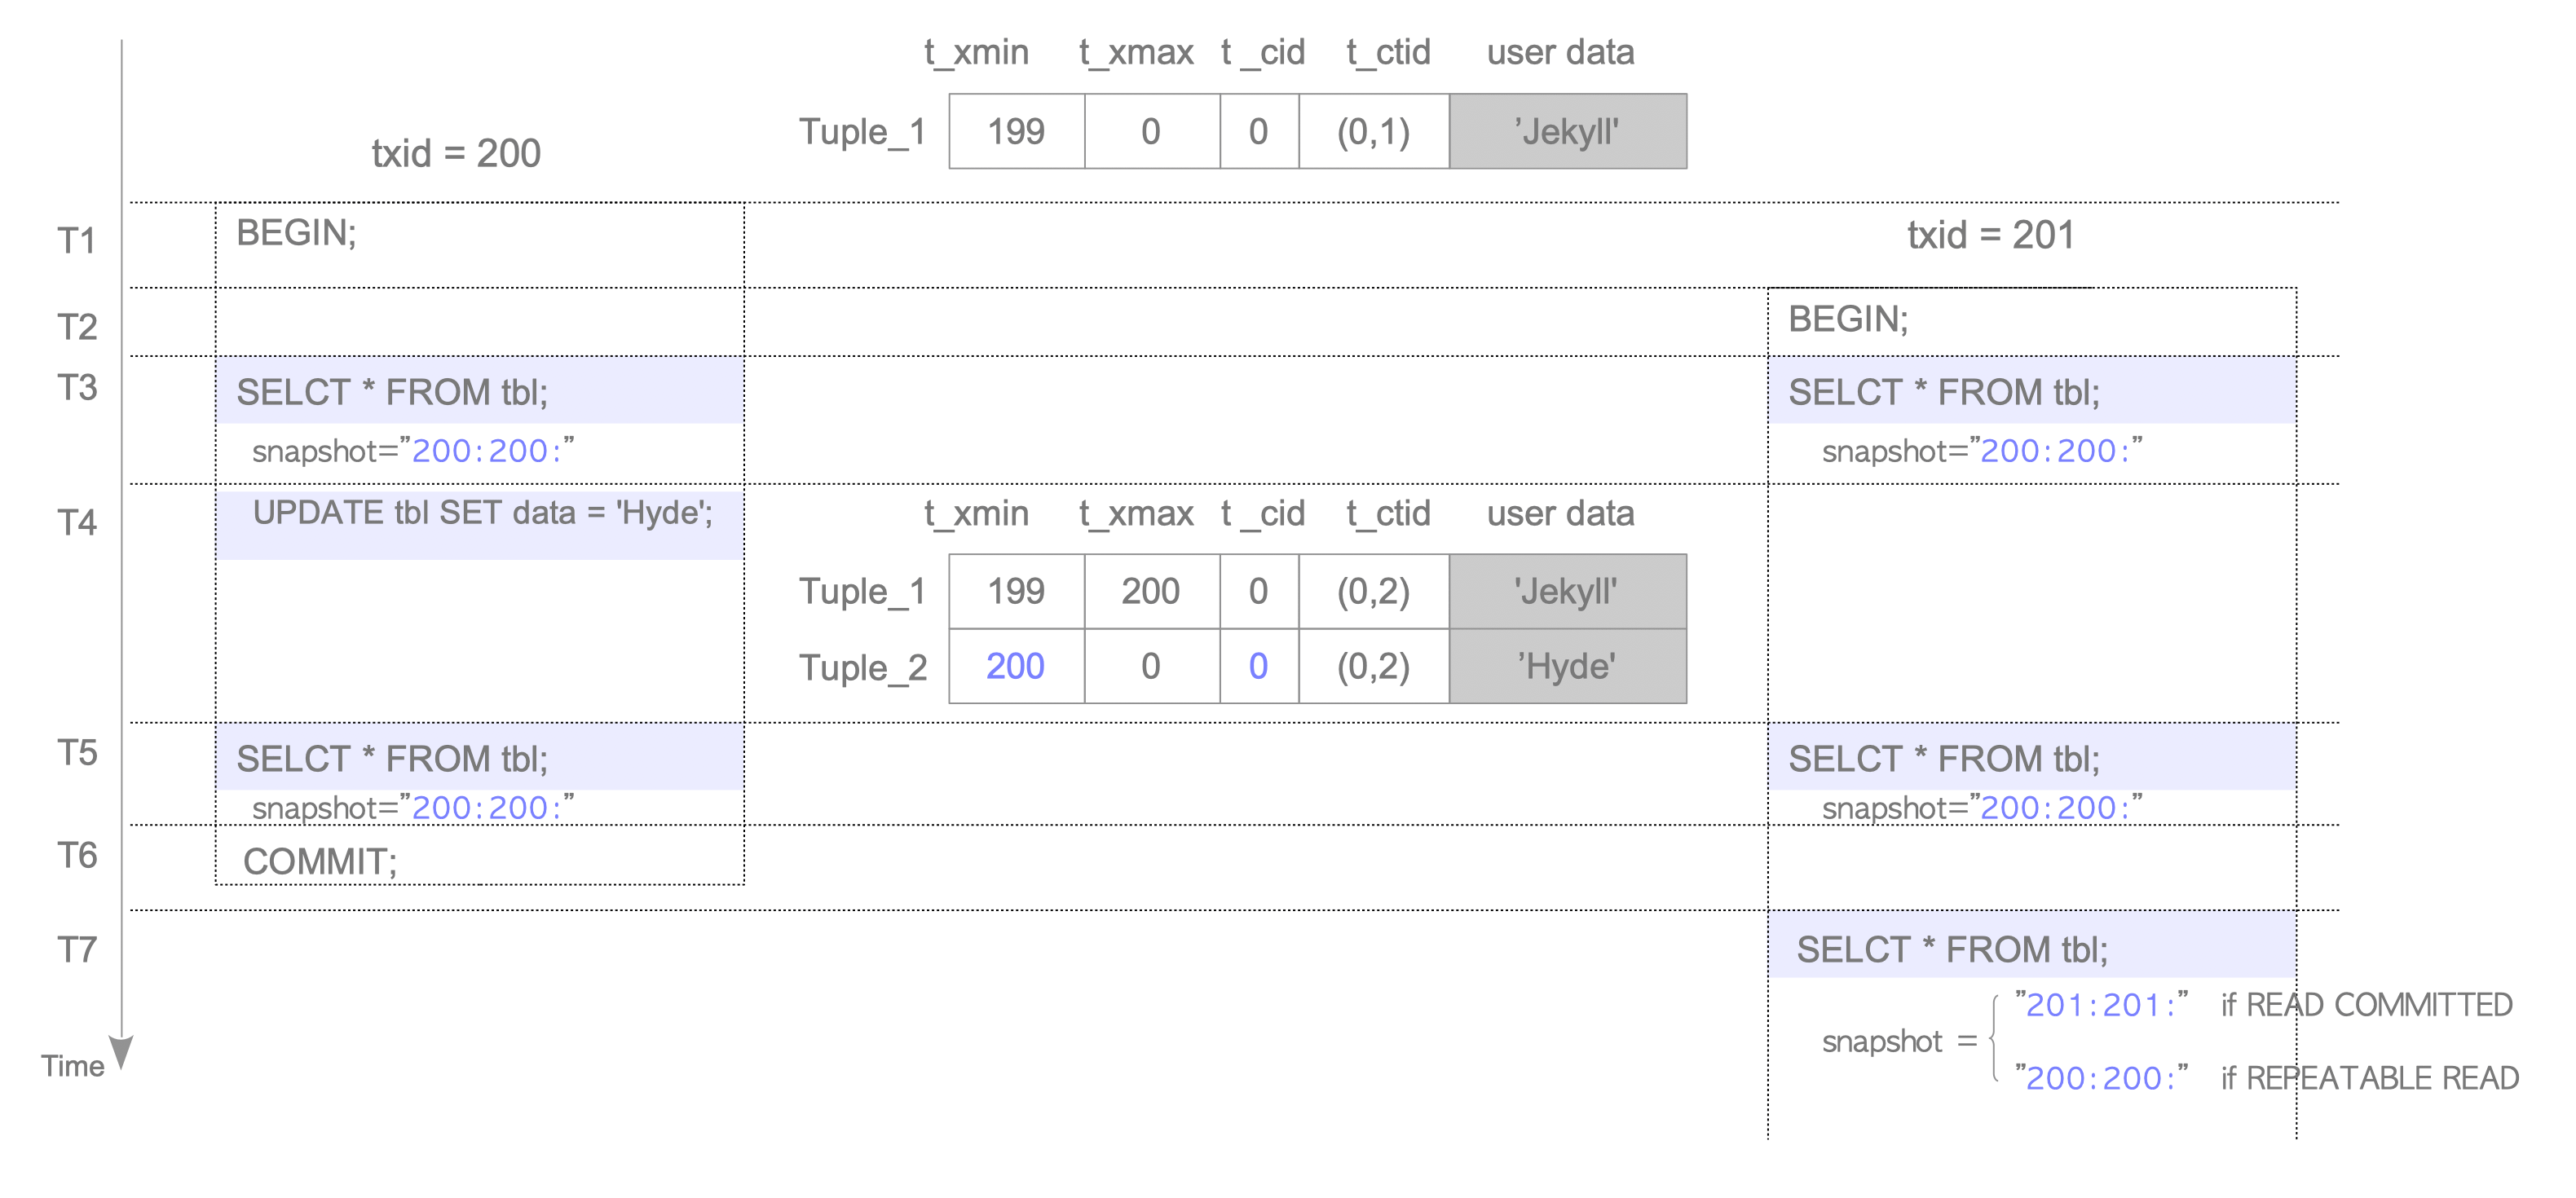

- 시나리오에서는 SQL 명령이 다음과 같은 시간 순서로 실행.

- T1: 트랜잭션 시작(txid 200)
- T2: 트랜잭션 시작(txid 201)
- T3: txid 200 및 201의 SELECT 명령 실행
- T4: txid 200의 UPDATE 명령을 실행.
- T5: txid 200 및 201의 SELECT 명령 실행
- T6: txid 200 커밋
- T7: txid 201의 SELECT 명령을 실행.

<br>

- 설명을 단순화하기 위해 txid 200과 201이라는 두 개의 트랜잭션만 있다고 가정.
- txid 200의 격리 수준은 READ COMMITTED이고 txid 201의 격리 수준은 READ COMMITTED 또는 REPEATABLE READ.

**SELECT 명령이 각 튜플에 대한 가시성 검사를 수행하는 방법.**

**T3의 선택 명령:**

- T3에서는 'tbl' 테이블에 Tuple_1만 있고 이는 규칙 6 에 의해 표시.
- 따라서 두 트랜잭션의 SELECT 명령은 'Jekyll'을 반환.

- 규칙6(Tuple_1) ⇒ Status(t_xmin:199) = COMMITTED  ∧ t_xmax = INVALID  ⇒ Visible



```
testdb=# -- txid 200
testdb=# SELECT * FROM tbl;
  name  
--------
 Jekyll
(1 row)


testdb=# -- txid 201
testdb=# SELECT * FROM tbl;
  name  
--------
 Jekyll
(1 row)
```

**T5의 선택 명령:**

- 먼저 txid 200에 의해 실행되는 SELECT 명령을 살펴봄.
- Tuple_1은 규칙 7 에 의해 보이지 않고 Tuple_2는 규칙 2 에 의해 표시 됨.
- 따라서 이 SELECT 명령은 'Hyde'를 반환.

- 규칙7(Tuple_1): Status(t_xmin:199) = COMMITTED ∧ Status(t_xmax:200) = IN_PROGRESS ∧ t_xmax:200 = current_txid:200 ⇒ invisible

- 규칙2(Tuple_2): Status(t_xmin:200) = IN_PROGRESS ∧  t_xmin:200 = current_txid:200 ∧  t_xmax = INVAILD ⇒ Visible

```
testdb=# -- txid 200
testdb=# SELECT * FROM tbl;
 name
------
 Hyde
(1 row)
```

- 반면, txid 201이 실행한 SELECT 명령에서 Tuple_1은 Rule 8 에 의해 표시되고 Tuple_2는 Rule 4 에 의해 표시되지 않음 .
- 따라서 이 SELECT 명령은 'Jekyll'을 반환.

- 규칙8(Tuple_1): Status(t_xmin:199) = COMMITTED ∧ Status(t_xmax:200) = IN_PROGRESS ∧ t_xmax:200 ≠ current_txid:201 ⇒ Visible

- 규칙4(Tuple_2): Status(t_xmin:200) = IN_PROGRESS ∧ t_xmin:200 ≠  current_txid:201 ⇒  Invisible

```
testdb=# -- txid 201
testdb=# SELECT * FROM tbl;
  name  
--------
 Jekyll
(1 row)
```

- 업데이트된 튜플이 커밋되기 전에 다른 트랜잭션에서 볼 수 있는 경우 이를 Dirty Reads(더티 읽기) , wr-con충돌 이라고도 함 .
- 그러나 위에 표시된 것처럼 Dirty Reads는 PostgreSQL의 어떤 격리 수준에서도 발생하지 않음.

**T7의 선택 명령:**

**다음에서는 두 격리 수준 모두에서 T7의 SELECT 명령 동작을 설명.**

- txid 201이 READ COMMITTED 레벨이면 트랜잭션 스냅샷이 '201:201:'이므로 txid 200은 COMMITTED로 처리됨
- 따라서 Tuple_1은 규칙 10 에 의해 표시되지 않고 Tuple_2는 규칙 6 에 의해 표시 됨 .
- SELECT 명령은 'Hyde'를 반환.

- 규칙10(Tuple_1): Status(t_xmin:199) = COMMITTED ∧ Status(t_xmax:200) = COMMITTED  ∧
 Snapshot(t_xmax:200) ≠ active  ⇒ Invisible

- 규칙6(Tuple_2): Status(t_xmin:200) = COMMITTED ∧ t_xmax = INVALID  ⇒ Visible


```
testdb=# -- txid 201 (READ COMMITTED)
testdb=# SELECT * FROM tbl;
 name
------
 Hyde
(1 row)
```

- txid 200이 커밋되기 전과 후에 실행되는 SELECT 명령의 결과가 다르다는 점에 유의
  - 이는 일반적으로 Non-Repeatable Reads 로 알려져 있음.

- 반면 txid 201이 REPEATABLE READ 수준인 경우 트랜잭션 스냅샷이 '200:200:'이므로 txid 200은 IN_PROGRESS로 처리되어야 함.
- 따라서 Tuple_1은 규칙 9 에 의해 표시되고 Tuple_2는 규칙 5 에 의해 표시되지 않음.
- SELECT 명령은 'Jekyll'을 반환.

- 반복 불가능 읽기는 REPEATABLE READ(및 SERIALIZABLE) 수준에서는 발생하지 않음.

- 규칙9(Tuple_1): Status(t_xmin:199) = COMMITTED ∧ Status(t_xmax:200) = COMMITTED  ∧
 Snapshot(t_xmax:200) = active  ⇒ Visible

- 규칙5(Tuple_2): Status(t_xmin:200) = COMMITTED ∧ Snapshot(t_xmin:200) = active   ⇒ Invisible

```
testdb=# -- txid 201 (REPEATABLE READ)
testdb=# SELECT * FROM tbl;
  name  
--------
 Jekyll
(1 row)
```

**Hint Bits**

- 트랜잭션 상태를 얻기 위해 PostgreSQL은 내부적으로 TransactionIdIsInProgress, TransactionIdDidCommit 및 TransactionIdDidAbort의 세 가지 기능을 제공.
- 이러한 기능은 캐시와 같은 막힘에 대한 빈번한 액세스를 줄이기 위해 구현.
- 그러나 각 튜플을 검사할 때마다 실행하면 병목 현상이 발생.

- 이 문제를 해결하기 위해 PostgreSQL은 다음과 같이 힌트 비트를 사용.

```
#define HEAP_XMIN_COMMITTED       0x0100   /* t_xmin committed */
#define HEAP_XMIN_INVALID         0x0200   /* t_xmin invalid/aborted */
#define HEAP_XMAX_COMMITTED       0x0400   /* t_xmax committed */
#define HEAP_XMAX_INVALID         0x0800   /* t_xmax invalid/aborted */
```

- 튜플을 읽거나 쓸 때 PostgreSQL은 가능한 경우 힌트 비트를 튜플의 t_informask로 설정.
  - 예를 들어 PostgreSQL이 튜플의 t_xmin 상태를 확인하고 COMMITTED 상태를 얻는다고 가정.
  - 이 경우 PostgreSQL은 힌트 비트 HEAP_XMIN_COMMITTED를 튜플의 t_infomask로 설정.
  - 힌트 비트가 이미 설정된 경우 TransactionIdDidCommit 및 TransactionIdDidAbort는 더 이상 필요하지 않음.
  -  따라서 PostgreSQL은 각 튜플의 t_xmin 및 t_xmax 상태를 효율적으로 확인할 수 있음.

**Phantom Reads in PostgreSQL’s REPEATABLE READ Level**

- ANSI SQL-92 표준에 정의된 REPEATABLE READ는 Phantom Reads를 허용
- 그러나 PostgreSQL의 구현에서는 이를 허용하지 않음.
-  SI에서는 원칙적으로 Phantom Read를 허용하지 않음.

- 두 개의 트랜잭션, 즉 Tx_A와 Tx_B가 동시에 실행되고 있다고 가정.
  - 격리 수준은 READ COMMITTED 및 REPEATABLE READ이고 txid는 각각 100과 101.
  - 먼저 Tx_A는 튜플을 삽입.
  - 그런 다음 커밋.
  - 삽입된 튜플의 t_xmin은 100.

- 다음으로 Tx_B는 SELECT 명령을 실행.
- 그러나 Tx_A에 의해 삽입된 튜플은 규칙 5 에 따라 표시되지 않음
- 따라서 Phantom Read가 발생하지 않음.

- 규칙5(new tuple): Status(t_xmin:100) = COMMITTED ∧ Snapshot(t_xmin:100) = active   ⇒ Invisible



```
testdb=# -- Tx_A: txid 100
testdb=# START TRANSACTION
testdb-#  ISOLATION LEVEL READ COMMITTED;
START TRANSACTION
testdb=# SELECT txid_current();
 txid_current
--------------
          100
(1 row)

testdb=# INSERT INTO tbl(id, data)
                VALUES (1,'phantom');
INSERT 1
testdb=# COMMIT;
COMMIT
testdb=# -- Tx_B: txid 101
testdb=# START TRANSACTION
testdb-#  ISOLATION LEVEL REPEATABLE READ;
START TRANSACTION
testdb=# SELECT txid_current();
 txid_current
--------------
          101
(1 row)






testdb=# SELECT * FROM tbl WHERE id=1;
 id | data
----+------
(0 rows)
```